In [3]:
# Loading libraries
import unicodedata
import string
import re
import random
import time
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
USE_CUDA = True


In [4]:
# Creating a list of standard vocabulary to chnage input to * when out of vocab words are found. 
#This will be used for every input from a user and if his word not in the vocab then we
# can just replace it with UNK token. Hence just to generate UNK token, this vocab needs ot be loaded in the 
# memory

f = open('/home/ubuntu/cnn-dailymail-master/finished_files/vocab')
vocab = []
for id,item in enumerate(f):
    if id < 50000:
        vocab.append(item.strip().split('\2')[0])
f.close()
    

In [30]:
# helper class to index and count words in the sentence. This works at the sentence level
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # Count SOS and EOS
      
    def index_words(self, sentence):
        if len(sentence.split(' ')) > 1:
            for word in sentence.split(' '):
                self.index_word(word)
        else:
            for word in sentence:
                self.index_word(word)
            

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1



In [24]:

import re
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s) # replace with space
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s) # replace when not with space
    return s


In [25]:
# read the files, returns two objects with langs and pairs
import unicodedata
def read_file():
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/fra.txt.bz2').read().strip().split('\n')
    
    # Split every line into pairs and normalize
    return [[normalize_string(s) for s in l.split('\t')] for l in lines]
        

In [31]:
#Preprocessing the data
import numpy as np
import random 
pairs= np.array(read_file())
english= list(pairs[:,0])

MIN_WORD_LENGTH = 2
MAX_LENGTH = 300 # Char

# Creating the output class from vocab


good_prefixes = {
   'i m ': 'i am ',
   'he s ': 'he is' ,
   'she s ': 'she is ' ,
   'you re ': 'you are '
}

# replacing bad prefixes with the good ones
def replace_prefix(p):
    if len(p.split(' ')) > MIN_WORD_LENGTH:
        for key in good_prefixes.keys():
            p.replace(key,good_prefixes[key])
        return p
    else:
        return False
    
input_lang= Lang('eng')
output_lang= Lang('eng')

input_variable = []
output_variable = []
for sentence in english:
    sentence_tmp = replace_prefix(sentence)
    if sentence_tmp != False:
        input_variable_tmp = ''
        for char in sentence_tmp.replace(' ',''):
            rnd = np.random.rand()
            if  rnd  <.9:
                input_variable_tmp =  input_variable_tmp + char
            elif rnd > .9 and rnd <.95:
                input_variable_tmp =  input_variable_tmp + random.choice('abcdefghijklmnopqrstuvwxyz.!?')
            else:
                pass
        input_lang.index_words(input_variable_tmp)
        input_variable.append(input_variable_tmp)
        output_lang.index_words(sentence_tmp)
        output_variable.append(sentence_tmp)
    
            

            
print('Data processed as per input and output needs')


Reading lines...
Data processed as per input and output needs


In [44]:
# Converting input to torch tensors
# Return a list of indexes, one for each word in the sentence
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence]

def variable_from_sentence(lang, sentence):
    if len(sentence.split(' ')) > 1:
        sentence = sentence.split(' ')
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    var = Variable(torch.LongTensor(indexes).view(-1, 1))
#     print('var =', var)
    if USE_CUDA: var = var.cuda()
    return var


  


In [7]:
# In wiki pedia replace - every character except ?,.'- to these
# Replace numbers/decimals with a identifier
# Omit sentences with unicode
# we will use the NMT way of vocabulary

In [34]:

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, word_inputs, hidden):
        # Note: we run this all at once (over the whole input sequence)
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

In [35]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size, max_length=MAX_LENGTH):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        seq_len = len(encoder_outputs)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(seq_len)) # B x 1 x S
        if USE_CUDA: attn_energies = attn_energies.cuda()

        # Calculate energies for each encoder output
        for i in range(seq_len):
            attn_energies[i] = self.score(hidden, encoder_outputs[i])

        # Normalize energies to weights in range 0 to 1, resize to 1 x 1 x seq_len
        return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)
    
    def score(self, hidden, encoder_output):
        
        if self.method == 'dot':
            energy = hidden.dot(encoder_output)
            return energy
        
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = hidden.dot(energy)
            return energy
        
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = self.other.dot(energy)
            return energy

In [36]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        # Keep parameters for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size * 2, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)
    
    def forward(self, word_input, last_context, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        
        # Combine embedded input word and last context, run through RNN
        rnn_input = torch.cat((word_embedded, last_context.unsqueeze(0)), 2)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs; apply to encoder outputs
        attn_weights = self.attn(rnn_output.squeeze(0), encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        
        # Final output layer (next word prediction) using the RNN hidden state and context vector
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)))
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, context, hidden, attn_weights

In [37]:
teacher_forcing_ratio = 0.5
clip = 5.0

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):

    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Get size of input and target sentences
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    # Run words through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    # Choose whether to use teacher forcing
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        
        # Teacher forcing: Use the ground-truth target as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output[0], target_variable[di])
            decoder_input = target_variable[di] # Next target is next input

    else:
        # Without teacher forcing: use network's own prediction as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output[0], target_variable[di])
            
            # Get most likely word index (highest value) from output
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            
            decoder_input = Variable(torch.LongTensor([[ni]])) # Chosen word is next input
            if USE_CUDA: decoder_input = decoder_input.cuda()

            # Stop at end of sentence (not necessary when using known targets)
            if ni == EOS_token: break

    # Backpropagation
    loss.backward()
    torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0] / target_length

In [48]:
# functions to calculate estimated time and finished time
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [46]:
attn_model = 'general'
hidden_size = 500
n_layers = 2
dropout_p = 0.05

# Initialize models
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers)
decoder = AttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers, dropout_p=dropout_p)

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# Initialize optimizers and criterion
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()
# Configuring training
n_epochs = 50000
plot_every = 200
print_every = 1

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

In [ ]:
# Begin!
for epoch in range(1, n_epochs + 1):
    
    # Get training data for this cycle/epoch
    training_index = random.choice(range(0,len(input_variable)))
    input_var = variable_from_sentence(input_lang,input_variable[training_index]) # These are tensors
    target_var = variable_from_sentence(output_lang,output_variable[training_index]) # These are tensors

    # Run the train function
    loss = train(input_var, target_var, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss

    if epoch == 0: continue

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

0m 41s (- 34987m 50s) (1 0%) 9.4330
0m 42s (- 17561m 10s) (2 0%) 9.4515
0m 42s (- 11746m 59s) (3 0%) 9.4166
0m 42s (- 8866m 7s) (4 0%) 7.8667
0m 42s (- 7119m 14s) (5 0%) 9.3447
0m 42s (- 5949m 32s) (6 0%) 5.4059
0m 42s (- 5114m 47s) (7 0%) 9.3736
0m 43s (- 4492m 2s) (8 0%) 9.3373
0m 43s (- 3999m 15s) (9 0%) 2.3631
0m 43s (- 3610m 13s) (10 0%) 9.3142
0m 43s (- 3286m 34s) (11 0%) 2.3485
0m 43s (- 3020m 39s) (12 0%) 9.2509
0m 43s (- 2795m 10s) (13 0%) 9.2066
0m 43s (- 2598m 38s) (14 0%) 0.6826
0m 43s (- 2435m 20s) (15 0%) 9.2249
0m 43s (- 2285m 7s) (16 0%) 1.4986
0m 44s (- 2156m 50s) (17 0%) 9.1947
0m 44s (- 2039m 1s) (18 0%) 1.1742
0m 44s (- 1938m 14s) (19 0%) 9.1465
0m 44s (- 1844m 54s) (20 0%) 8.9025
0m 44s (- 1761m 20s) (21 0%) 9.1224
0m 44s (- 1682m 46s) (22 0%) 1.4288
0m 44s (- 1615m 5s) (23 0%) 9.0019
0m 45s (- 1562m 15s) (24 0%) 9.2116
0m 45s (- 1503m 31s) (25 0%) 9.0453
0m 45s (- 1450m 28s) (26 0%) 8.8619
0m 45s (- 1398m 8s) (27 0%) 1.2957
0m 45s (- 1356m 6s) (28 0%) 8.9372
0m 45

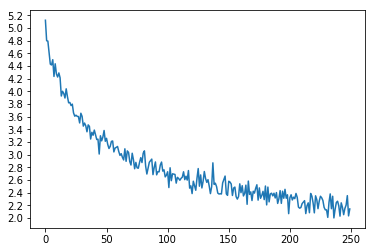

In [52]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

In [50]:
1

1

In [54]:
# evaluate
def evaluate(sentence, max_length=MAX_LENGTH):
    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    
    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([[SOS_token]])) # SOS
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([[ni]]))
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

In [111]:
def evaluate_randomly():
    ind = random.choice(range(0,len(input_variable)))
    output_words, decoder_attn = evaluate(input_variable[ind])
    #output_words, decoder_attn = evaluate('iwuldlyktosharemyprblmdatihvemenstruationprblmsincealongtym.')
    output_sentence = ' '.join(output_words)
    print('>',input_variable[ind] )
    print('=', output_variable[ind])
    print('<', output_sentence)
    print('')

In [169]:
evaluate_randomly()

> dotmakefunofthatcaild.
= don t make fun of that child .
< don t make fun of that . i can . <EOS>



In [170]:
evaluate_randomly()

> iwonderwhathamadehimehangehisind.
= i wonder what has made him change his mind .
< i wonder what what had his mind . <EOS>



In [171]:
evaluate_randomly()

> ithinktomwantsourhelp.
= i think tom wants our help .
< i think tom wants to help . <EOS>



In [172]:
evaluate_randomly()

> lastyeaidecidedtocomtojaa.
= last year i decided to come to japan .
< stay stayed to to to . <EOS>



In [98]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

def evaluate_and_show_attention(input_sentence):
    output_words, attentions = evaluate(input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    show_attention(input_sentence, output_words, attentions)

input = ihvestomachpain.
output = i have to make . <EOS>


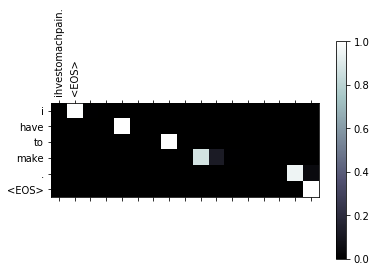

In [101]:
evaluate_and_show_attention('ihvestomachpain.')